In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
from cvxpy import multiply,maximum
import random
plt.rcParams.update({'figure.max_open_warning': 0})

# **Parsing the files**

In [2]:
#Format file for HomeB
epochTime=1388534400
df = pd.read_csv('./data/HomeB-meter1_2014.csv')
wf = pd.read_csv('./data/homeB2014.csv')
weather= list(wf['temperature'])
usage = list(df['use [kW]'][:16704])
tstamp=[]
temp=[]

for i in range(len(usage)):
    ts=pd.to_datetime(epochTime,unit='s')
    tstamp.append(ts)
    epochTime+=1800
    k=int(i/2) 
    temp.append(weather[k])
    
homeB = pd.Series(usage, name = 'load_demand[kW]')
homeB = pd.DataFrame(homeB)
homeB['time_stamp']=tstamp
homeB['temper']=temp

In [3]:
#Format file for HomeC
epochTime=1420070400
df = pd.read_csv('./data/HomeC-meter1_2015.csv')
wf = pd.read_csv('./data/homeC2015.csv')
weather= list(wf['temperature'])
usage = list(df['use [kW]'][0:16704])
tstamp=[]
temp=[]

for i in range(len(usage)):
    ts=pd.to_datetime(epochTime,unit='s')
    tstamp.append(ts)
    epochTime+=1800
    k=int(i/2) 
    temp.append(weather[k])

homeC = pd.Series(usage, name = 'load_demand[kW]')
homeC = pd.DataFrame(homeC)
homeC['time_stamp']=tstamp
homeC['temper']=temp

In [4]:
#Format file for HomeF
epochTime=1451606400
df = pd.read_csv('./data/HomeF-meter3_2016.csv')
wf = pd.read_csv('./data/homeF2016.csv')
weather= list(wf['temperature'])
usage = list(df['Usage [kW]'][:501091])
half_hour=[]
tstamp=[]
temp=[]

for i in range(0,len(usage),30):
    tot=sum(usage[i:i+30])/30
    ts=pd.to_datetime(epochTime,unit='s')
    tstamp.append(ts)
    epochTime+=1800 
    half_hour.append(tot)

for i in range(len(half_hour)):
    k=int(i/2)
    temp.append(weather[k])

homeF = pd.Series(half_hour, name = 'load_demand[kW]')
homeF = pd.DataFrame(homeF)
homeF['time_stamp']=tstamp
homeF['temper']=temp
tot_data=[homeB,homeC,homeF]

# **Prediction Models**
1. Moving Average
2. Linear Regression

In [5]:
#1. Moving Average
for house_data in tot_data:
    house_data['moving_avg'] = house_data['load_demand[kW]'].rolling(48,min_periods=1).mean()

In [6]:
#2. Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

for house_data in tot_data:
    home = house_data.drop(['time_stamp'], axis = 1)
    columns = home.columns

    X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(home[columns[1:]],\
                                                      home[columns[0]], train_size=0.7, random_state=0)

    regressor = LinearRegression()  
    regressor.fit(X_train_lin, y_train_lin)
    y_pred = regressor.predict(home[columns[1:]])

    house_data['linear_reg']=y_pred

**Extract data for required time period(Nov 1-Nov 14)**

In [7]:
k=1
all_house={}
for home in tot_data:
    if k==1:
        year='2014'
        name='homeB'
    elif k==2:
        year='2015'
        name='homeC'
    else:
        year='2016'
        name='homeF'

    start=year+'-11-01 00:00:00'
    end=year+'-11-15 00:00:00'

    period=(home['time_stamp'] >= start) & (home['time_stamp'] < end)
    all_house[name]=home.loc[period]
    all_house[name]=all_house[name].reset_index(drop=True)
    k+=1

In [8]:
all_house['homeB']

,load_demand[kW],time_stamp,temper,moving_avg,linear_reg
0,0.454203,2014-11-01 00:00:00,44.07,0.550403,0.562079
1,0.458466,2014-11-01 00:30:00,44.07,0.541504,0.554610
2,0.361272,2014-11-01 01:00:00,43.65,0.534678,0.548031
3,0.505893,2014-11-01 01:30:00,43.65,0.534446,0.547836
4,0.404497,2014-11-01 02:00:00,43.49,0.534703,0.547729
...,...,...,...,...,...
667,0.580181,2014-11-14 21:30:00,30.88,0.561381,0.544579
668,0.636204,2014-11-14 22:00:00,30.56,0.564851,0.546844
669,0.513729,2014-11-14 22:30:00,30.56,0.566585,0.548299
670,0.740532,2014-11-14 23:00:00,29.70,0.570104,0.549510


# **Cost Functions**

In [9]:
def costFn(x,y,p,a,b,n=None):
    res = 0
    if not n:
        for t in range(len(y)):
            res += (p*x[t] + a*np.maximum(0,y[t]-x[t]) + b*np.absolute(x[t]-x[t-1]))
    else:
        for t in range(n):
            res += (p*x[t] + a*np.maximum(0,y[t]-x[t]) + b*np.absolute(x[t]-x[t-1]))
    return res

def DynamicFn(x,y,p,a,b):
    F = 0
    for t in range(len(y)):
        F += (multiply(p,x[t]) + multiply(a,maximum(0,y[t]-x[t])) + multiply(b,cvx.abs(x[t]-x[t-1])))
    return F

def StaticFn(x,y,p,a):

    F = 0
    for t in range(len(y)):
        F += (multiply(p,x) + multiply(a,maximum(0,y[t]-x)))
    return F

# **1.Offline Algorithms**
**Offline Static**



In [10]:
def offlineStatic(y,p,a):
    x = cvx.Variable(1)
    objective = cvx.Minimize(StaticFn(x,y,p,a))
    constraints = [x >= 0]
    prob = cvx.Problem(objective, constraints)
    res = prob.solve(solver=cvx.SCS)
    return x,res

**Offline Dynamic**

In [11]:
def offlineDynamic(y,p,a,b):
    x = cvx.Variable(len(y))
    objective = cvx.Minimize(DynamicFn(x,y,p,a,b))
    constraints = [x >= 0]
    prob = cvx.Problem(objective, constraints)
    prob.solve(solver=cvx.SCS)
    return x.value

# **2. Online Algorithms**
**Online Gradient Descent**

In [12]:
def ogd(y,s,p,a,b):
    x = [0]*len(y)
    def gradient(t):
        res = p
        if y[t] > x[t]:
            if x[t] < x[t-1]:
                res-=(a+b)
        elif y[t] <= x[t]:
            if x[t] < x[t-1]:
                res-=b
            elif x[t] > x[t-1]:
                res+=b
        return res

    for t in range(len(y)-1):
        ss = s
        if t>0:
            ss/=np.sqrt(t)
        x[t+1] = x[t] - ss*(gradient(t))
    return x

**Receding Horizon Control**

In [13]:
def rhc(y,n,w,p,a,b):
    x = [0]*n
    for t in range(n):
        x_rhc = cvx.Variable(w)
        y_hat = y[t:t+w]
        objective = cvx.Minimize(DynamicFn(x_rhc,y_hat,p,a,b))
        constraints = [x_rhc >= 0]
        prob = cvx.Problem(objective, constraints)
        prob.solve(solver=cvx.SCS)
        x[t] = x_rhc.value[0]
    return x

**Commitment Horizon Control**

In [14]:
def chc(y,n,w,v,p,a,b):
    x = [0]*n
    for t in range(n):
        x_rhc = cvx.Variable(w)
        y_hat = y[t:t+w]
        objective = cvx.Minimize(DynamicFn(x_rhc,y_hat,p,a,b))
        constraints = [x_rhc >= 0]
        prob = cvx.Problem(objective, constraints)
        prob.solve(solver=cvx.SCS)
        for i in range(v):
            if t+i<n:
                val = x_rhc.value[i]
                x[t+i] += val
    for i in range(v-1,n):
        x[i]/=v
    for i in range(1,v-1):
        x[i]/=(i+1)
    return x

## Output using different values of parameters. 


**Using different values for step size.**

In [15]:
steps=[0.01, 0.05, 0.1, 0.5, 1]
a=1/2
b=2/2
p=0.4/2

print("Online Gradient Descent Cost")
print("============================")
for step in steps:
    print("Step size:",step)
    for home in all_house:
        y=np.asarray(all_house[home]['load_demand[kW]'])
        x = ogd(y,step,p,a,b)
        cost = costFn(x,y,p,a,b)
        print(home+": %.5f" %cost)
    print()


Online Gradient Descent Cost
Step size: 0.01
homeB: 178.81228
homeC: 220.83781
homeF: 440.10817

Step size: 0.05
homeB: 129.31317
homeC: 171.22591
homeF: 356.29337

Step size: 0.1
homeB: 129.97036
homeC: 168.20425
homeF: 343.59002

Step size: 0.5
homeB: 148.36560
homeC: 188.48466
homeF: 363.18620

Step size: 1
homeB: 173.69895
homeC: 212.35817
homeF: 389.32345



**Using different values for window size.**

In [16]:
a=4/2
b=4/2
p=0.4/2
n=672

windows=[3,5,7,9,11]
print("Receding Horizon Control Cost")
print("=============================\n")

for wind_size in windows:
    
    print("Window Size:",wind_size)
    for home in all_house:
        print("-----",home,"-----")

        y=np.asarray(all_house[home]['load_demand[kW]'])
        y1=np.asarray(all_house[home]['moving_avg'])
        y2=np.asarray(all_house[home]['linear_reg'])

        x1 = rhc(y1,n,wind_size,p,a,b)
        cost1 = costFn(x1,y,p,a,b,n)
        print('MAVG_RHC: %.5f' %cost1)

        x2 = rhc(y2,n,wind_size,p,a,b)
        cost2 = costFn(x2,y,p,a,b,n)
        print('LINEAR_RHC: %.5f' %cost2)
    print()


Receding Horizon Control Cost

Window Size: 3
----- homeB -----
MAVG_RHC: 232.80153
LINEAR_RHC: 231.55338
----- homeC -----
MAVG_RHC: 343.20469
LINEAR_RHC: 338.64186
----- homeF -----
MAVG_RHC: 813.04809
LINEAR_RHC: 812.66692

Window Size: 5
----- homeB -----
MAVG_RHC: 229.20210
LINEAR_RHC: 228.40897
----- homeC -----
MAVG_RHC: 336.73118
LINEAR_RHC: 333.27949
----- homeF -----
MAVG_RHC: 802.66587
LINEAR_RHC: 804.97591

Window Size: 7
----- homeB -----
MAVG_RHC: 226.96833
LINEAR_RHC: 226.40923
----- homeC -----
MAVG_RHC: 331.55018
LINEAR_RHC: 329.14882
----- homeF -----
MAVG_RHC: 795.21284
LINEAR_RHC: 799.92877

Window Size: 9
----- homeB -----
MAVG_RHC: 225.60229
LINEAR_RHC: 225.11737
----- homeC -----
MAVG_RHC: 327.04963
LINEAR_RHC: 325.30377
----- homeF -----
MAVG_RHC: 790.18615
LINEAR_RHC: 796.42102

Window Size: 11
----- homeB -----
MAVG_RHC: 225.15000
LINEAR_RHC: 224.81899
----- homeC -----
MAVG_RHC: 325.67004
LINEAR_RHC: 323.94191
----- homeF -----
MAVG_RHC: 788.76597
LINEAR_RHC:

**Usind different values for commitment levels.**

In [17]:
a=4/2
b=4/2
p=0.4/2
wind_size=9
n=672

commitments=[2,4,6]
print("Commitment Horizon Control Cost")
print("===============================\n")

for c in commitments:
    print("Commitment Level:",c)
    for home in all_house:
        print("-----",home,"-----")

        y=np.asarray(all_house[home]['load_demand[kW]'])
        y1=np.asarray(all_house[home]['moving_avg'])
        y2=np.asarray(all_house[home]['linear_reg'])

        x1 = chc(y1,n,wind_size,c,p,a,b)
        cost1 = costFn(x1,y,p,a,b,n)
        print('MAVG_CHC: %.5f' %cost1)

        x2 = chc(y2,n,wind_size,c,p,a,b)
        cost2 = costFn(x2,y,p,a,b,n)
        print('LINEAR_CHC: %.5f' %cost2)
    print()


Commitment Horizon Control Cost

Commitment Level: 2
----- homeB -----
MAVG_CHC: 225.71445
LINEAR_CHC: 225.14569
----- homeC -----
MAVG_CHC: 327.81760
LINEAR_CHC: 326.00167
----- homeF -----
MAVG_CHC: 790.51481
LINEAR_CHC: 796.58017

Commitment Level: 4
----- homeB -----
MAVG_CHC: 226.05354
LINEAR_CHC: 225.41897
----- homeC -----
MAVG_CHC: 329.22728
LINEAR_CHC: 327.32403
----- homeF -----
MAVG_CHC: 791.50267
LINEAR_CHC: 796.93296

Commitment Level: 6
----- homeB -----
MAVG_CHC: 226.53093
LINEAR_CHC: 225.81663
----- homeC -----
MAVG_CHC: 330.59954
LINEAR_CHC: 328.62531
----- homeF -----
MAVG_CHC: 792.97432
LINEAR_CHC: 797.41731



# **Final calculations using selected parameter values**

In [18]:
a=4/2
b=4/2
p=0.4/2
step_size=0.1
wind_size=9
commitment=4
n=672
final={'Off_Stat':[],
      'Off_Dyna':[],
      'OGD':[],
      'MAVG_RHC':[],
      'LINEAR_RHC':[],
      'MAVG_CHC':[],
      'LINEAR_CHC':[]
      }

off_cols=['Off_Stat','Off_Dyna']
rhc_cols=['MAVG_RHC','LINEAR_RHC']
chc_cols=['MAVG_CHC','LINEAR_CHC']

for home in all_house:
    print("-----",home,"-----")

    y=np.asarray(all_house[home]['load_demand[kW]'])
    y1=np.asarray(all_house[home]['moving_avg'])
    y2=np.asarray(all_house[home]['linear_reg'])

    col_name=off_cols[0]
    x,cost=offlineStatic(y,p,a)
    val=x.value[0]
    x_stat=[val]*672
    all_house[home][col_name]=x_stat
    final['Off_Stat'].append(cost)
    print(col_name+': %.5f' %cost)

    col_name=off_cols[1]
    x = offlineDynamic(y,p,a,b)
    off_dyna=costFn(x,y,p,a,b)
    all_house[home][col_name]=x
    final['Off_Dyna'].append(off_dyna)
    print(col_name+': %.5f' %off_dyna)

    col_name='OGD'
    x = ogd(y,step_size,p,a,b)
    cost = costFn(x,y,p,a,b)
    all_house[home][col_name] = x
    final['OGD'].append(cost)
    print(col_name+': %.5f' %cost)

    col_name=rhc_cols[0]
    x = rhc(y1,n,wind_size,p,a,b)
    cost = costFn(x,y,p,a,b,n)
    all_house[home][col_name] = x
    final['MAVG_RHC'].append(cost)
    print(col_name+': %.5f' %cost)

    col_name=rhc_cols[1]
    x = rhc(y2,n,wind_size,p,a,b)
    cost = costFn(x,y,p,a,b,n)
    all_house[home][col_name] = x
    final['LINEAR_RHC'].append(cost)
    print(col_name+': %.5f' %cost)

    col_name=chc_cols[0]
    x = chc(y1,n,wind_size,commitment,p,a,b)
    cost = costFn(x,y,p,a,b,n)
    all_house[home][col_name] = x
    final['MAVG_CHC'].append(cost)
    print(col_name+': %.5f' %cost)

    col_name=chc_cols[1]
    x = chc(y2,n,wind_size,commitment,p,a,b)
    cost = costFn(x,y,p,a,b,n)
    all_house[home][col_name] = x
    final['LINEAR_CHC'].append(cost)
    print(col_name+': %.5f' %cost)
    print()


----- homeB -----
Off_Stat: 192.50065
Off_Dyna: 160.39251
OGD: 219.05454
MAVG_RHC: 225.60229
LINEAR_RHC: 225.11737
MAVG_CHC: 226.05354
LINEAR_CHC: 225.41897

----- homeC -----
Off_Stat: 257.28039
Off_Dyna: 209.88195
OGD: 287.62609
MAVG_RHC: 327.04963
LINEAR_RHC: 325.30377
MAVG_CHC: 329.22728
LINEAR_CHC: 327.32403

----- homeF -----
Off_Stat: 638.46939
Off_Dyna: 491.68934
OGD: 786.71901
MAVG_RHC: 790.18615
LINEAR_RHC: 796.42102
MAVG_CHC: 791.50267
LINEAR_CHC: 796.93296



# Comparison Report

In [19]:
report=pd.DataFrame({
    'Houses': ['Home B(2014)','Home C(2015)', 'Home F(2016)'],
    'Offline Static':final['Off_Stat'],
    'Offline Dynamic':final['Off_Dyna'],
    'Online Gradient Descent':final['OGD'],
    'Receding Horizon Control(Moving Avg.)':final['MAVG_RHC'],
    'Receding Horizon Control(Linear Reg.)':final['LINEAR_RHC'],
    'Commitment Horizon Control(Moving Avg.)':final['MAVG_CHC'],
    'Commitment Horizon Control(Linear Reg.)':final['LINEAR_CHC']
}, index=range(1,4))

report

,Houses,Offline Static,Offline Dynamic,Online Gradient Descent,Receding Horizon Control(Moving Avg.),Receding Horizon Control(Linear Reg.),Commitment Horizon Control(Moving Avg.),Commitment Horizon Control(Linear Reg.)
1,Home B(2014),192.500651,160.392507,219.054541,225.602290,225.117370,226.053545,225.418968
2,Home C(2015),257.280387,209.881952,287.626093,327.049632,325.303772,329.227275,327.324025
3,Home F(2016),638.469395,491.689337,786.719014,790.186148,796.421021,791.502668,796.932961


# Graph Plots

In [20]:
def plot_graphs(home,algo,head):
  
    x=all_house[home][algo]

    if 'MAVG' in algo:
        y=all_house[home]['moving_avg']
    elif 'LINEAR' in algo:
        y=all_house[home]['linear_reg']
    else:
        y=all_house[home]['load_demand[kW]']

    if home=='homeB':
        heading="Home B 2014 "+head
    elif home=='homeC':
        heading="Home C 2015 "+head
    else:
        heading="Home F 2016 "+head

    fig= plt.figure(figsize=(13,5))
    plt.title(heading)
    plt.plot(y, label="Energy Demand",color='green', linewidth=0.7)
    plt.plot(x, label="Energy Supplied", color='coral')
    plt.legend()
    plt.ylabel("Electricity Units")
    plt.xlabel("Time (1Unit=30Mins)")


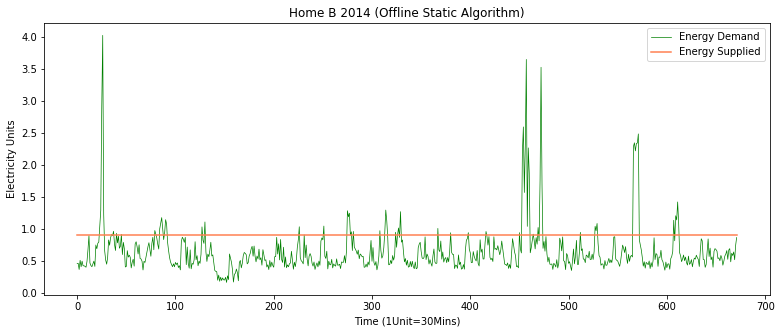

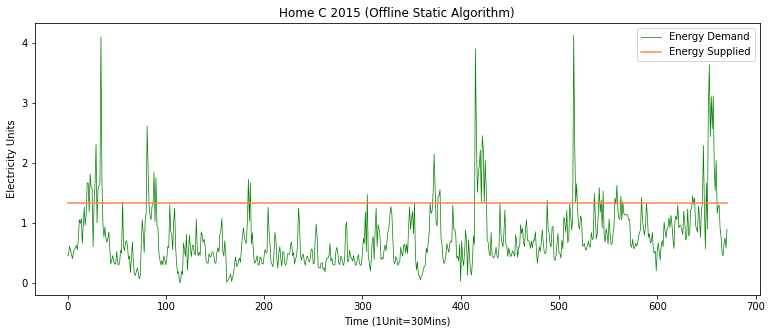

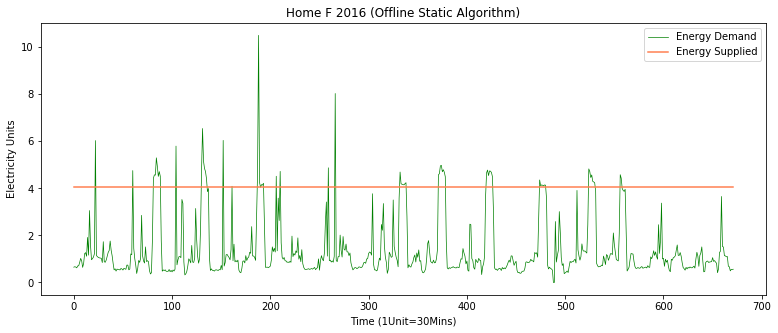

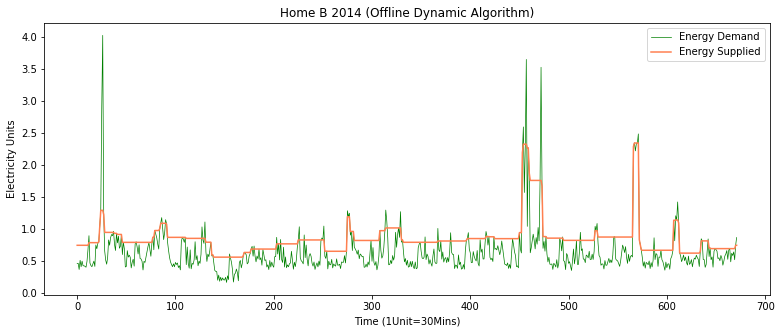

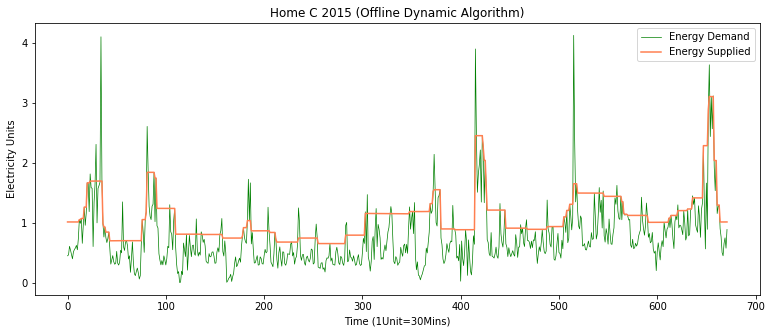

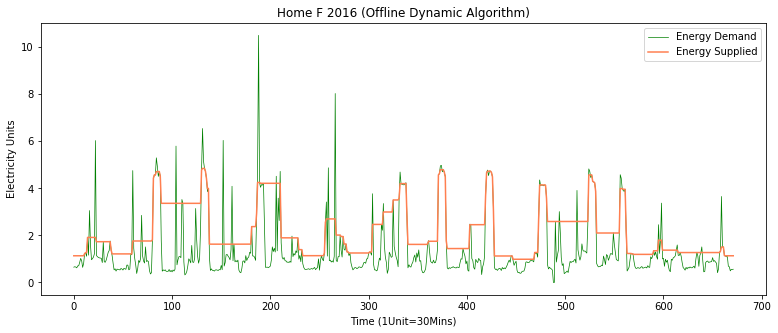

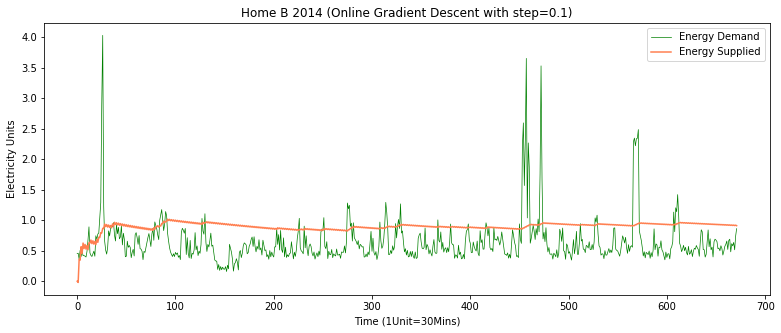

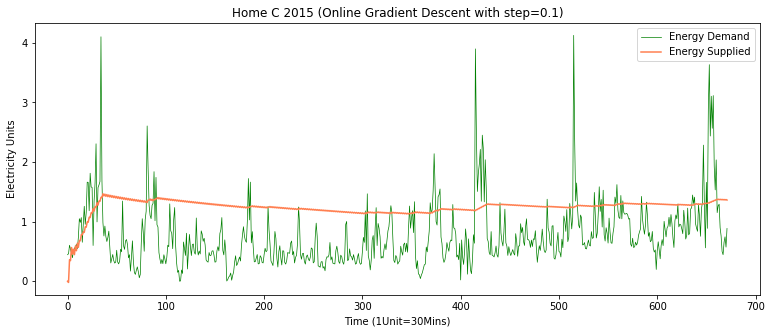

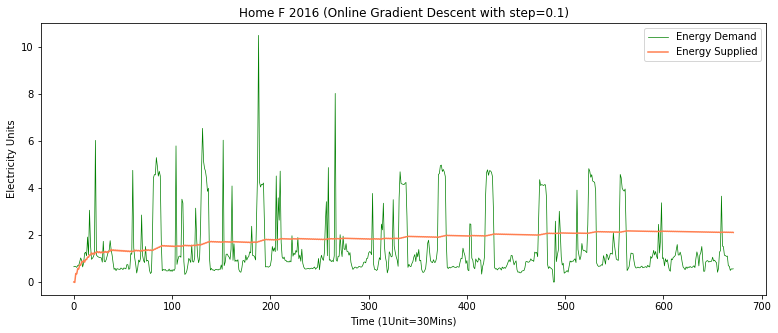

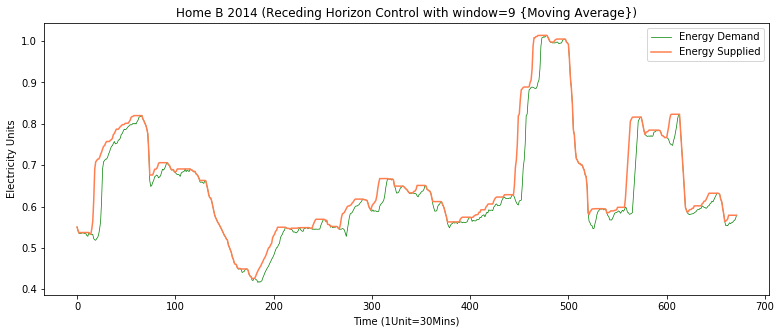

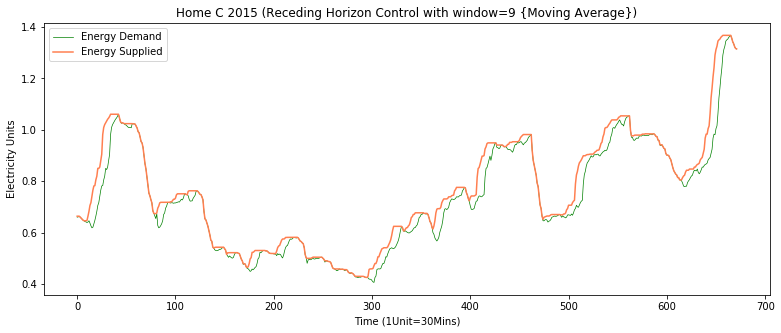

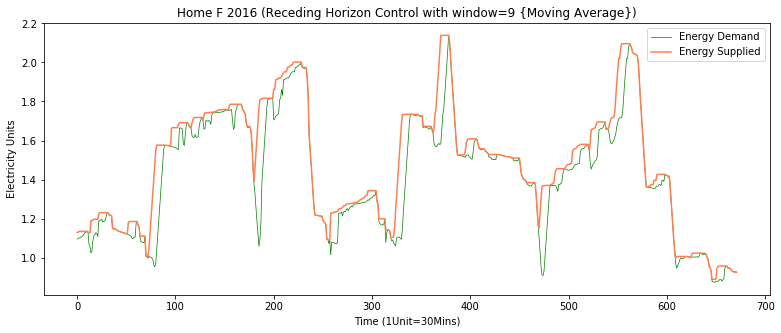

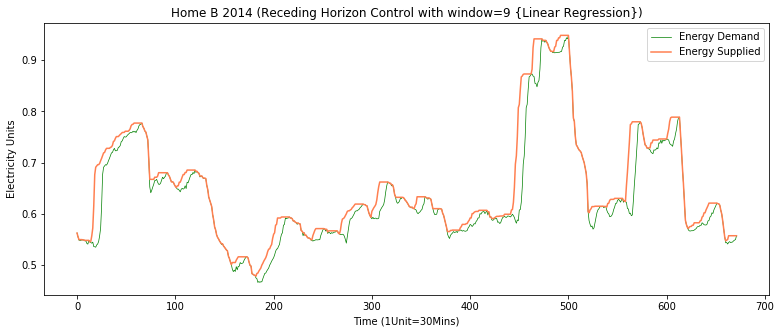

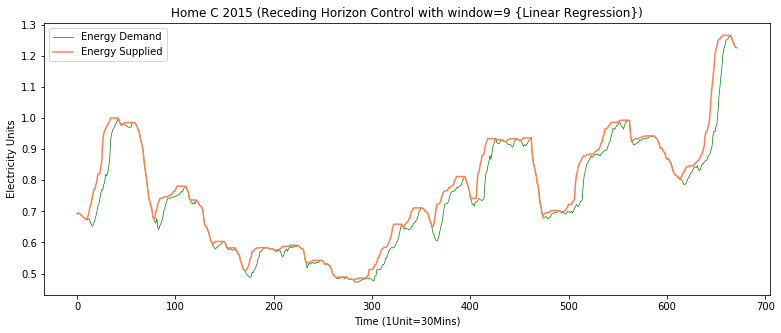

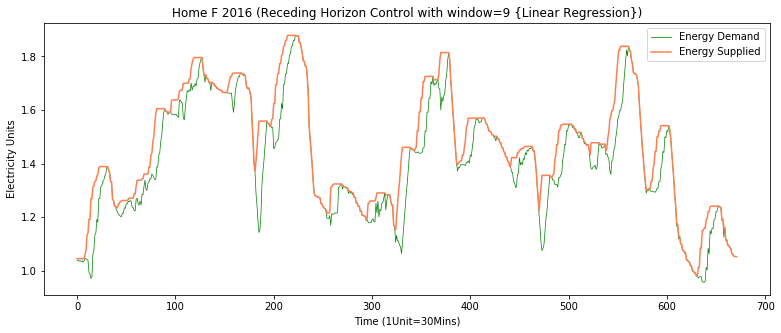

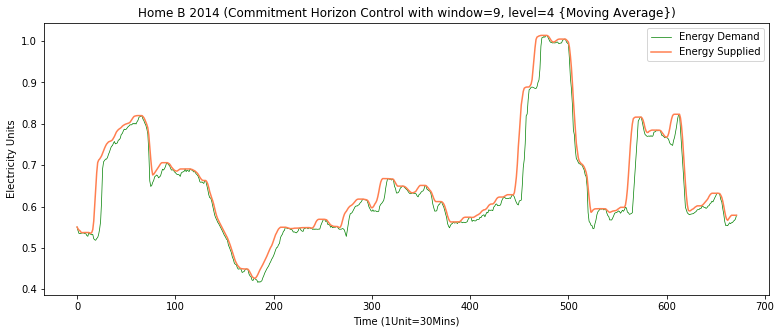

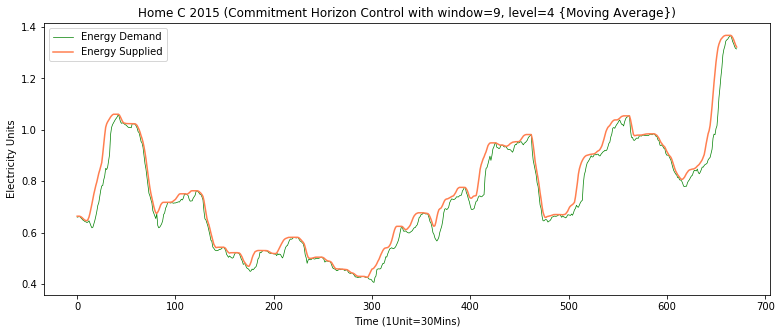

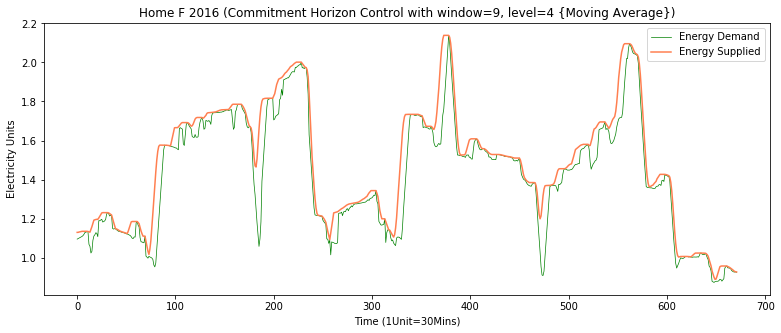

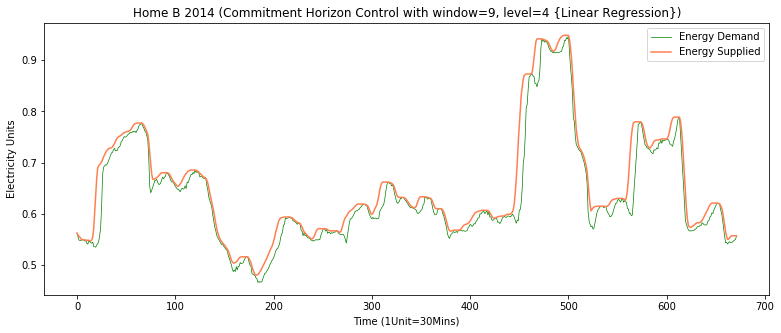

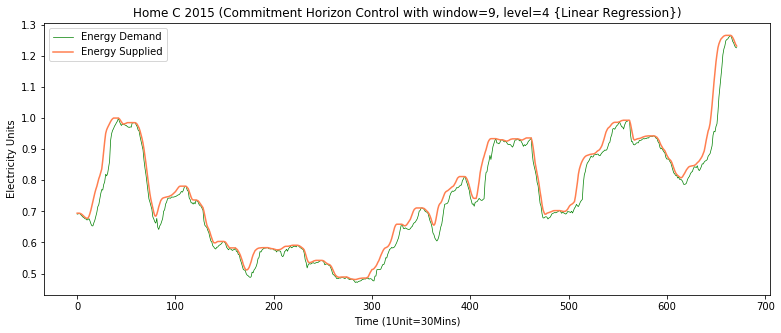

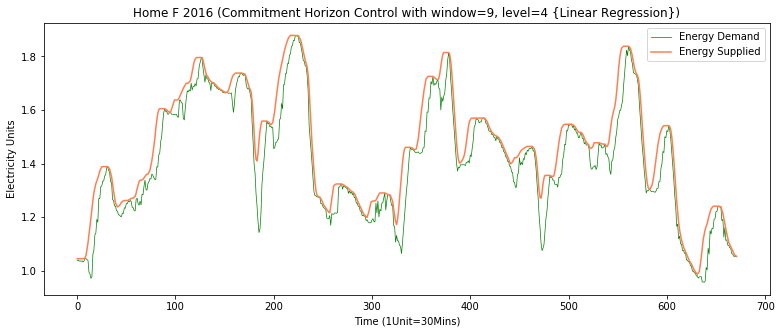

In [21]:
algos={'Off_Stat':'(Offline Static Algorithm)',
       'Off_Dyna':'(Offline Dynamic Algorithm)',
       'OGD':'(Online Gradient Descent with step=0.1)', 
       'MAVG_RHC':'(Receding Horizon Control with window=9 {Moving Average})', 
       'LINEAR_RHC':'(Receding Horizon Control with window=9 {Linear Regression})', 
       'MAVG_CHC':'(Commitment Horizon Control with window=9, level=4 {Moving Average})',
       'LINEAR_CHC':'(Commitment Horizon Control with window=9, level=4 {Linear Regression})'	
      }

for algo in algos:
    for home in all_house:
        plot_graphs(home,algo,algos[algo])


### **Trying different values for 'a' and 'b' in RHC(Linear Regression)**

In [22]:
penalty=[8,6,2] #penalty cost
switch=[2,6,8] #Switching cost

p = 0.40/2 # p is the electricity price
n = 672
wind_size=9

for i in range(len(penalty)):    
    a=penalty[i]/2
    b=switch[i]/2
    print('a:',a*2, '& b:',b*2)
    print('---------------')
    for home in all_house:
        y=np.asarray(all_house[home]['load_demand[kW]'])
        y1=np.asarray(all_house[home]['linear_reg'])
        x = rhc(y1,n,wind_size,p,a,b)
        cost = costFn(x,y,p,a,b,n)
        print(home+': %.5f' %cost)
    print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
    print()


a: 8.0 & b: 2.0
---------------
homeB: 354.60580
homeC: 535.63878
homeF: 1372.23405
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

a: 6.0 & b: 6.0
---------------
homeB: 293.79093
homeC: 436.28517
homeF: 1096.09801
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

a: 2.0 & b: 8.0
---------------
homeB: 164.45231
homeC: 226.81379
homeF: 520.82355
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx



# Algorithm Selection
### **Deterministic**

In [23]:
intervals=8
p=0.4/2
a=4/2
b=4/2
n=672
step=0.1
wind_size=9
commitment=4
weights=[1,1,1]

print("Minimum Optimal Values at different intervals")
print("=============================================")

for home in all_house:
    tot_cost=0
    y=np.asarray(all_house[home]['load_demand[kW]'])
    y1=np.asarray(all_house[home]['moving_avg'])
    
    algo = {'OGD':0, 
            'RHC':0, 
            'CHC':0
            }

    for i in range(0,n,intervals):
        costs=[]
        y_int=y[i:i+intervals]
        y1_int=y1[i:i+intervals]
        
        x = offlineDynamic(y_int,p,a,b)
        off_dyna=costFn(x,y_int,p,a,b)
    
        x1 = ogd(y_int,step,p,a,b)
        cost1=costFn(x1,y_int,p,a,b,intervals)
        costs.append(abs(off_dyna-cost1))
        
        x2 = rhc(y1_int,intervals,wind_size,p,a,b)
        cost2=costFn(x2,y_int,p,a,b,intervals)
        costs.append(abs(off_dyna-cost2))

        x3 = chc(y1_int,intervals,wind_size,commitment,p,a,b)
        cost3=costFn(x3,y_int,p,a,b,intervals)
        costs.append(abs(off_dyna-cost3))
        
        cost_min= min(costs)
        best=costs.index(cost_min)
        
        if weights[0]==weights[1]==weights[2]:
            chosen=1
        else:
            max_wt=max(weights)
            chosen=weights.index(max_wt)
        
        if chosen==0:
            algo['OGD']+=1
            tot_cost+=cost1
        elif chosen==1:
            algo['RHC']+=1
            tot_cost+=cost2
        else:
            algo['CHC']+=1
            tot_cost+=cost3
        
        if chosen!=best:
            weights[chosen]-=0.1        
            
    
    print("-----",home,"-----")
    print("Total Intervals:", n/intervals)
    print('OGD Used:',algo['OGD'],'times')
    print('RHC Used:',algo['RHC'],'times')
    print('CHC Used:',algo['CHC'],'times')
    print("Optimal value: %.5f" %tot_cost)
    print()


Minimum Optimal Values at different intervals
----- homeB -----
Total Intervals: 84.0
OGD Used: 8 times
RHC Used: 9 times
CHC Used: 67 times
Optimal value: 270.23746

----- homeC -----
Total Intervals: 84.0
OGD Used: 10 times
RHC Used: 11 times
CHC Used: 63 times
Optimal value: 420.10343

----- homeF -----
Total Intervals: 84.0
OGD Used: 12 times
RHC Used: 12 times
CHC Used: 60 times
Optimal value: 951.22283



### **Random**

In [24]:
intervals=12
p=0.4/2
a=4/2
b=4/2
n=672
step=0.1
wind_size=9
commitment=4

print("Minimum Optimal Values at different intervals")
print("=============================================")

for home in all_house:
    tot_cost=0
    y=np.asarray(all_house[home]['load_demand[kW]'])
    y1=np.asarray(all_house[home]['linear_reg'])
    
    algo = {'OGD':0, 
            'RHC':0, 
            'CHC':0
            }
    
    for i in range(0,n,intervals):
        y_int=y[i:i+intervals]
        y1_int=y1[i:i+intervals]
        
        chosen = random.randint(1,3)
        
        if chosen==1:
            algo['OGD']+=1
            x = ogd(y_int,step,p,a,b)
            
        elif chosen==2:    
            algo['RHC']+=1
            x = rhc(y1_int,intervals,wind_size,p,a,b)

        else:
            algo['CHC']+=1
            x = chc(y1_int,intervals,wind_size,commitment,p,a,b)
            
        tot_cost+=costFn(x,y_int,p,a,b,intervals)
            
    print("-----",home,"-----")
    print("Total Intervals:", n/intervals)
    print('OGD Used:',algo['OGD'],'times')
    print('RHC Used:',algo['RHC'],'times')
    print('CHC Used:',algo['CHC'],'times')
    print("Optimal value: %.5f" %tot_cost)
    print()



Minimum Optimal Values at different intervals
----- homeB -----
Total Intervals: 56.0
OGD Used: 20 times
RHC Used: 17 times
CHC Used: 19 times
Optimal value: 356.80862

----- homeC -----
Total Intervals: 56.0
OGD Used: 15 times
RHC Used: 16 times
CHC Used: 25 times
Optimal value: 428.16122

----- homeF -----
Total Intervals: 56.0
OGD Used: 15 times
RHC Used: 21 times
CHC Used: 20 times
Optimal value: 1012.66968

